# BeachBoys BikeShare

BeachBoys BikeShare is een 

## Importeer Libraries

In [165]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [166]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import numpy as np
import shap


# Download en importeer data bestanden

We beginnen met eerst de nodige data in te laden.

In [167]:
# Dit commando opent een popup waar je je moet inloggen op je azure account
!az login

A web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "id": "4a429ac3-22e4-4b7f-a63f-6865c1b7edbe",
    "isDefault": true,
    "managedByTenants": [
      {
        "tenantId": "2f4a9838-26b7-47ee-be60-ccc1fdec5953"
      }
    ],
    "name": "Rootsacademy-Certifications",
    "state": "Enabled",
    "tenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "user": {
      "name": "bram.decoster@dataroots.io",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "id": "bc921e01-cc39-4564-9417-037822015aab",
    "isDefault": false,
    "managedByTenants": [
      {
        "tenantId": "2f4a9838-26

In [168]:
# Nu we zijn ingelogt kunnen we verbinden met de storage account en vervolgens de data uit de correcte container halen
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient

try:
    default_credential = DefaultAzureCredential() # regelt de authenticatie

    connection_string = "https://mowworkshopprep.blob.core.windows.net"
    blob_service_client = BlobServiceClient(connection_string,default_credential) #verbinden met de storage account
    container_name = "workshopdata"
    container_client = blob_service_client.get_container_client(container_name) #verbinden met de container

    local_path = "../data"

    blob_list = container_client.list_blobs() #lees alle bestanden in de container
    for blob in blob_list: # Ga over alle bestanden (blobs) en schrijf ze weg
        blob_client = container_client.get_blob_client(blob.name)    
        local_file_path = f"{local_path}/{blob.name}"
        with open(local_file_path, "wb") as local_file:
            local_file.write(blob_client.download_blob().readall())
    
    # Controleer of alle bestanden gedownload zijn
    required_files = ["station_data.csv", "trip_data.csv", "weather_data.csv", "previousValues.csv"]
    for file_name in required_files:
        file_path = os.path.join(local_path, file_name)
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_name} not found in the local folder.")
    print("All required files found in the local folder.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

All required files found in the local folder.


In [169]:
os.listdir("../data")

['.DS_Store',
 'station_data.csv',
 'weather_data.csv',
 'trip_data.csv',
 'previousValues.csv']

# Analyseer de Tabellen

De eerste stap is kijken welke data beschikbaar is, en of hier enkele opvallende trends in te vinden zijn. <br>
Het eerste bestand is 'station_data.csv', elke rij hier vertelt meer over een bepaald station: de locatie, het aantal plaatsen voor fietsen,... <br>
Het tweede bestand bevat een rij voor elke geregistreerde trip, en geeft aan waar en wanneer deze gestart/ beëindigt zijn. Dit is ook de grootste tabel aangezien het informatie bevat voor elke gemaakte trip.<br>
De laatste tabel is informatie over het weer in en rond San Francisco. 

## Station data

In [170]:
station_data = pd.read_csv("../data/station_data.csv")
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


Elk station bevat verschillende gegevens:
- id: een unieke getal voor elk station
- Name: Naam van het station
- Lat: breedtegraad
- Long: lengtegraad
- Dock count: aantal plaatsen voor fietsen in het station
- City: De stad waar het station zich bevind

In [171]:
column_types = station_data.dtypes
print(column_types)

Id              int64
Name           object
Lat           float64
Long          float64
Dock Count      int64
City           object
dtype: object


Het type 'object' betekent string in dit geval. Alle kolommen staan reeds in de juiste vorm.

Text(0, 0.5, 'Aantal Stations')

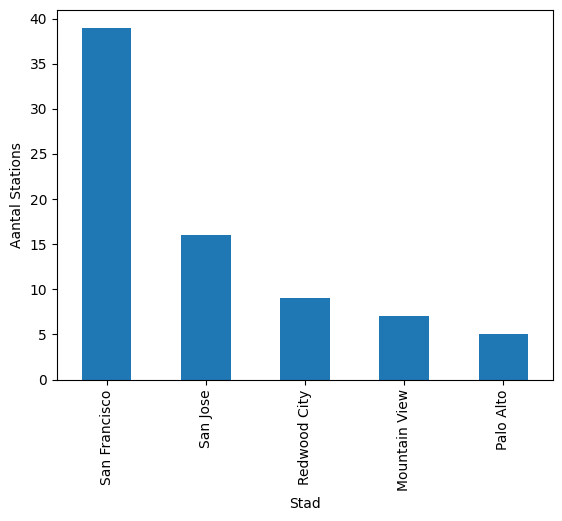

In [172]:
station_data['City'].value_counts().plot(kind="bar")
plt.xlabel("Stad")
plt.ylabel("Aantal Stations")

Text(0, 0.5, 'Totaal aantal fietsplaatsen')

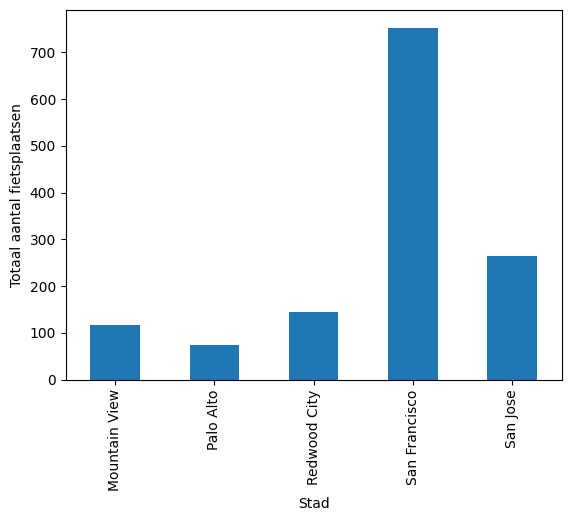

In [173]:
station_data.groupby(['City'])['Dock Count'].sum().plot(kind='bar')
plt.xlabel("Stad")
plt.ylabel("Totaal aantal fietsplaatsen")

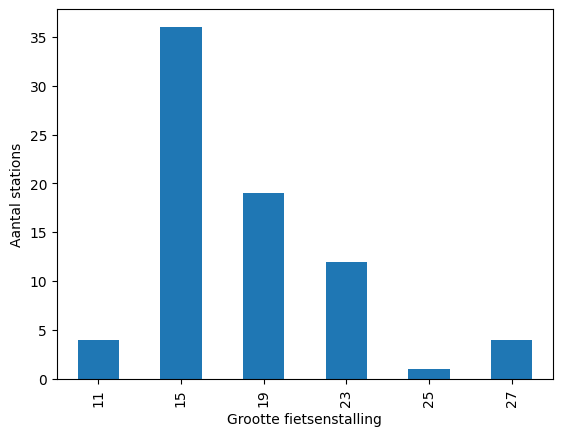

In [174]:
station_data['Dock Count'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Grootte fietsenstalling')        
plt.ylabel('Aantal stations')
plt.show()

We zien hier dat elk station tussen de 11 en 27 plaatsen voor fietsen bevatten, en het grootste aantal stations plaats voor 15 fietsen heeft.

## Trip data

In [175]:
trip_data = pd.read_csv("../data/trip_data.csv")
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,891070,14/08/2015 23:49,82,14/08/2015 23:55,42,Subscriber
1,891069,14/08/2015 23:49,82,14/08/2015 23:58,87,Subscriber
2,891068,14/08/2015 23:49,60,14/08/2015 23:54,74,Subscriber
3,891067,14/08/2015 23:48,59,14/08/2015 23:51,59,Subscriber
4,891066,14/08/2015 23:38,28,14/08/2015 23:53,27,Subscriber


Elke trip die een persoon maakt bevat de volgende gegevens:
- Trip ID: een uniek nummer voor elke trip
- Start Date: start tijd en datum van de trip
- Start Station: Waar is de trip begonnen
- End Date: eind tijd en datum van de trip
- End Station: Waar is de trip beëindigd
- Subscriber Type: Wat soort abonnement heeft de gebruiker

In [176]:
column_types = trip_data.dtypes
print(column_types)

Trip ID             int64
Start Date         object
Start Station       int64
End Date           object
End Station         int64
Subscriber Type    object
dtype: object


Hier zien we dat de start en eind tijd in string formaat staan. Hierdoor kunnen we niet redeneren over tijd, wat een belangrijk aspect is voor het voorspellen van het aantal fietsen. We moeten deze dus eerst transformeren.

In [177]:
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'], format='%d/%m/%Y %H:%M')
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'], format='%d/%m/%Y %H:%M')
print(trip_data.dtypes)

Trip ID                     int64
Start Date         datetime64[ns]
Start Station               int64
End Date           datetime64[ns]
End Station                 int64
Subscriber Type            object
dtype: object


In [178]:
minDate = trip_data['Start Date'].min()
minDate

Timestamp('2014-09-01 00:05:00')

In [179]:
maxDate = trip_data['End Date'].max()
maxDate

Timestamp('2015-08-14 23:58:00')

We zien nu dat we ongeveer 1 jaar aan data hebben van September 2014 tot en met Augustus 2015.

In [180]:
trip_data["tripDuration"] = (trip_data['End Date']-trip_data['Start Date']).dt.total_seconds()/60
trip_data

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0
...,...,...,...,...,...,...,...
336925,432951,2014-09-01 04:21:00,39,2014-09-01 04:32:00,65,Subscriber,11.0
336926,432950,2014-09-01 03:16:00,50,2014-09-01 05:08:00,70,Customer,112.0
336927,432949,2014-09-01 00:05:00,66,2014-09-01 00:14:00,57,Customer,9.0
336928,432948,2014-09-01 00:05:00,66,2014-09-01 00:15:00,57,Customer,10.0


count    336930.000000
mean         17.531333
std         512.855384
min           1.000000
25%           6.000000
50%           9.000000
75%          12.000000
max      287899.000000
Name: tripDuration, dtype: float64


Text(0, 0.5, '')

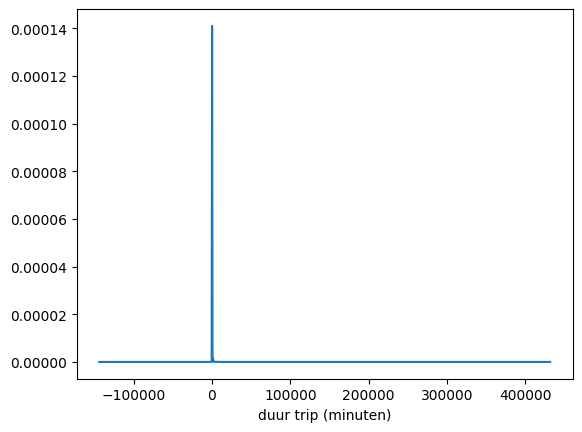

In [181]:
print(trip_data["tripDuration"].describe())
trip_data["tripDuration"].plot(kind='kde')
plt.xlabel('duur trip (minuten)')
plt.ylabel('')

De grafiek is niet zo overzichtelijk. Dit komt omdat er enkele trips tussen de gegevens zitten extreem lang geduurd zouden hebben.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


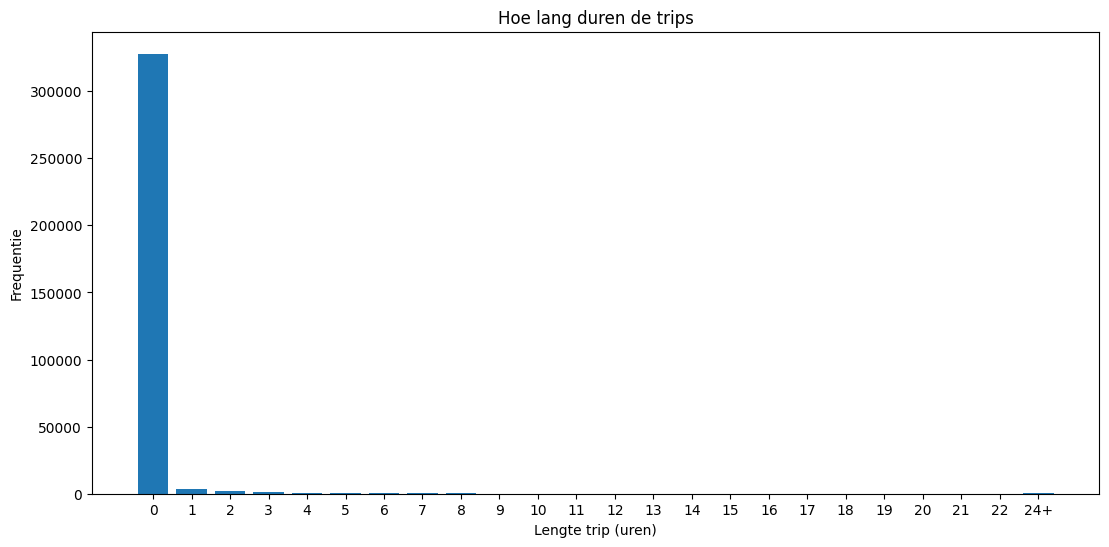

In [182]:
bin_edges = [i for i in range(0, 24, 1)] + [float('inf')]
bin_labels = [f'{i}' for i in range(0, 23, 1)] +['24+']

trip_data['duration_bins'] = pd.cut(trip_data['tripDuration']/60, bins=bin_edges, labels=bin_labels, right=False)
plt.figure(figsize=(13, 6))
plt.bar(bin_labels, trip_data.groupby('duration_bins').size())
plt.xlabel('Lengte trip (uren)')
plt.ylabel('Frequentie')
plt.title('Hoe lang duren de trips')

plt.show()


Als we dan iets verder inzoomen op de data zien we dat de overgrote hoeveelheid trips minder dan een uur zouden duren.

In [183]:
allRoutes = trip_data.groupby(['Start Station','End Station']).size().reset_index(name='trip_count')
popularRoutes = allRoutes.sort_values(by='trip_count', ascending=False).head(10)
popularRoutes

,Start Station,End Station,trip_count
741,50,60,2988
1085,61,50,2836
742,50,61,2524
790,51,70,2313
1596,74,61,2225
1068,60,74,2175
1259,65,70,2167
868,55,70,2070
1435,70,50,1992
1410,69,65,1988


In [184]:
print(station_data[station_data['Id'] == 50][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 60][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 61][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 70][['Id','Name','City','Dock Count']])

    Id                                  Name           City  Dock Count
42  50  Harry Bridges Plaza (Ferry Building)  San Francisco          23
    Id                    Name           City  Dock Count
51  60  Embarcadero at Sansome  San Francisco          15
    Id             Name           City  Dock Count
52  61  2nd at Townsend  San Francisco          27
    Id                                      Name           City  Dock Count
62  70  San Francisco Caltrain (Townsend at 4th)  San Francisco          19


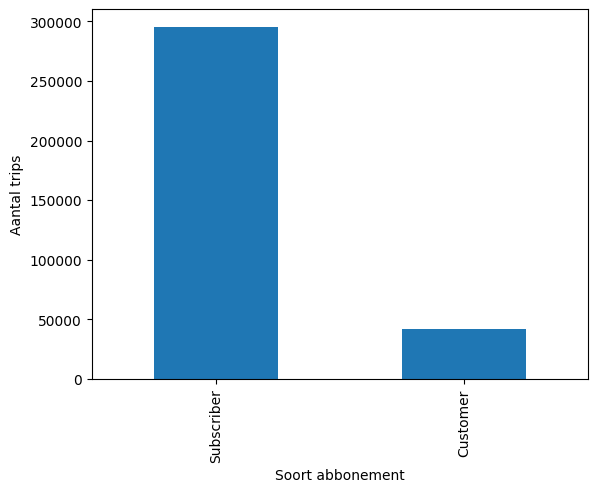

In [185]:
trip_data['Subscriber Type'].value_counts().plot(kind='bar')
plt.xlabel('Soort abbonement')        
plt.ylabel('Aantal trips')
plt.show()

Nu zou het interessant zijn om naar trends in de tijd te kunnen kijken. Zijn er spitsuren? Is het drukker tijdens het weekend of in de week? Is er een winterstop? Al deze vragen zijn relevant voor het voorspellen waar veel fietsen nodig zijn. <br>
Momenteel staan de tijdstippen opgeslagen in 1 kolom, onbewust kunnen wij dit in onze gedachten al opsplitsen in jaren, maanden, dagen, uren,...<br>
Maar het machine learning model kan dit niet, ook maakt dit het plotten meer ingewikkeld. Daarom splitsen we nu eerst de tijdstippen op.

In [186]:
# Splits Start Date op
trip_data['StartYear'] = trip_data['Start Date'].dt.year
trip_data['StartMonth'] = trip_data['Start Date'].dt.month
trip_data['StartDay'] = trip_data['Start Date'].dt.day
trip_data['StartWeekday'] = trip_data['Start Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['StartHour'] = trip_data['Start Date'].dt.hour
trip_data['StartMinute'] = trip_data['Start Date'].dt.minute

# Splits End Date op
trip_data['EndYear'] = trip_data['End Date'].dt.year
trip_data['EndMonth'] = trip_data['End Date'].dt.month
trip_data['EndDay'] = trip_data['End Date'].dt.day
trip_data['EndWeekday'] = trip_data['End Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['EndHour'] = trip_data['End Date'].dt.hour
trip_data['EndMinute'] = trip_data['End Date'].dt.minute

In [187]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


Nu we zeker zijn dat de datum correct gesplitst is kunnen de we de originele tijdstippen verwijderen.

In [188]:
trip_data = trip_data.drop('Start Date',axis=1)
trip_data = trip_data.drop('End Date',axis=1)
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,82,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,82,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,60,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,59,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,28,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


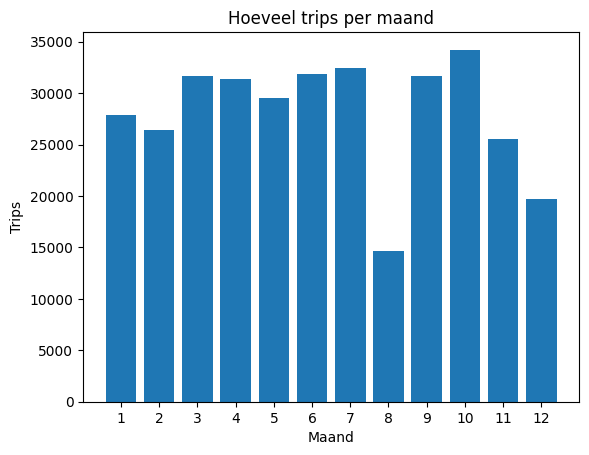

In [189]:
tripsPerMonth= trip_data['StartMonth'].value_counts().reset_index().sort_values(by= 'StartMonth')

plt.bar(tripsPerMonth['StartMonth'], tripsPerMonth['count'])
plt.xlabel('Maand')
plt.ylabel('Trips')
plt.xticks(tripsPerMonth['StartMonth'])
plt.title('Hoeveel trips per maand')
plt.show()


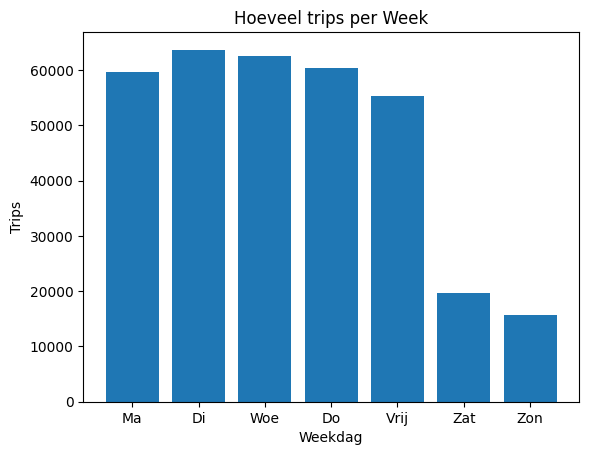

In [190]:
tripsPerWeek= trip_data['StartWeekday'].value_counts().reset_index().sort_values(by= 'StartWeekday')

plt.bar(tripsPerWeek['StartWeekday'], tripsPerWeek['count'])
plt.xlabel('Weekdag')
plt.ylabel('Trips')
plt.xticks(tripsPerWeek['StartWeekday'],['Ma', 'Di', 'Woe', 'Do', 'Vrij', 'Zat', 'Zon'])
plt.title('Hoeveel trips per Week')
plt.show()


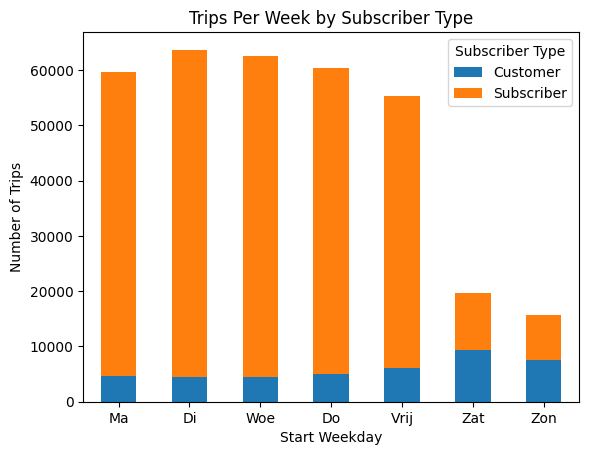

In [191]:
tripsPerWeek= trip_data.groupby(['StartWeekday','Subscriber Type']).size().unstack(fill_value=0)
fig, ax = plt.subplots()
tripsPerWeek.plot(kind='bar', stacked=True, ax=ax)

# Adding labels and title
ax.set_xlabel('Start Weekday')
ax.set_ylabel('Number of Trips')
ax.set_xticklabels(['Ma', 'Di', 'Woe', 'Do', 'Vrij', 'Zat', 'Zon'],rotation=0)
ax.set_title('Trips Per Week by Subscriber Type')

# Display the plot
plt.show()

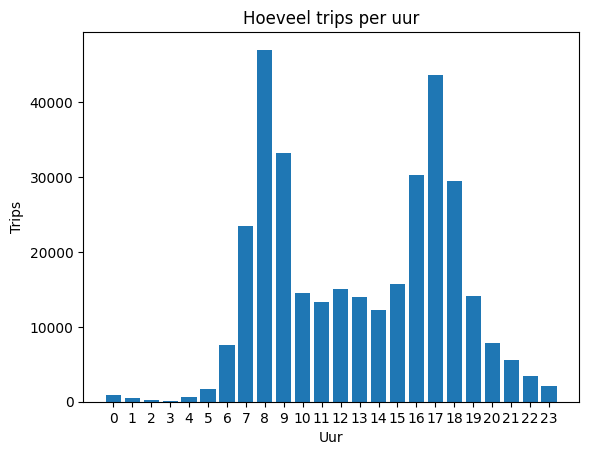

In [192]:
tripsPerHour= trip_data['StartHour'].value_counts().reset_index().sort_values(by= 'StartHour')

plt.bar(tripsPerHour['StartHour'], tripsPerHour['count'])
plt.xlabel('Uur')
plt.ylabel('Trips')
plt.xticks(tripsPerHour['StartHour'])
plt.title('Hoeveel trips per uur')
plt.show()


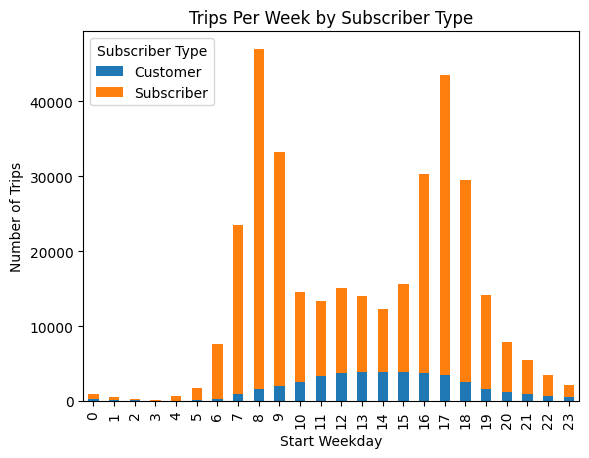

In [193]:
tripsPerWeek= trip_data.groupby(['StartHour','Subscriber Type']).size().unstack(fill_value=0)
fig, ax = plt.subplots()
tripsPerWeek.plot(kind='bar', stacked=True, ax=ax)

# Adding labels and title

ax.set_xlabel('Start Weekday')
ax.set_ylabel('Number of Trips')
ax.set_title('Trips Per Week by Subscriber Type')

# Display the plot
plt.show()

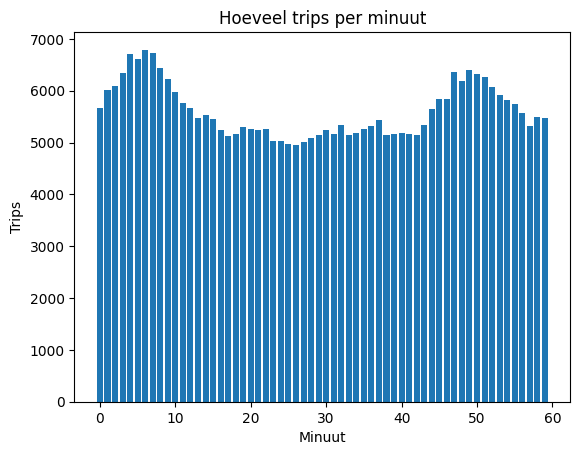

In [194]:
tripsPerHour= trip_data['StartMinute'].value_counts().reset_index().sort_values(by= 'StartMinute')

plt.bar(tripsPerHour['StartMinute'], tripsPerHour['count'])
plt.xlabel('Minuut')
plt.ylabel('Trips')
plt.title('Hoeveel trips per minuut')
plt.show()


In [195]:
weather_data = pd.read_csv("../data/weather_data.csv")
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [196]:
column_types = weather_data.dtypes
print(column_types)

Date                          object
Max TemperatureF             float64
Mean TemperatureF            float64
Min TemperatureF             float64
Max Dew PointF               float64
MeanDew PointF               float64
Min DewpointF                float64
Max Humidity                 float64
Mean Humidity                float64
Min Humidity                 float64
Max Sea Level PressureIn     float64
Mean Sea Level PressureIn    float64
Min Sea Level PressureIn     float64
Max VisibilityMiles          float64
Mean VisibilityMiles         float64
Min VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Wind SpeedMPH           float64
Max Gust SpeedMPH            float64
PrecipitationIn              float64
CloudCover                   float64
Events                        object
WindDirDegrees               float64
Zip                            int64
dtype: object


In [197]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')
weather_data['Mean TemperatureC'] = (weather_data['Mean TemperatureF'] - 32) * 5/9
weather_data['Mean TemperatureC'] = weather_data['Mean TemperatureC'].round(2)


In [198]:
weather_data['Zip'].value_counts()

Zip
94107    365
94063    365
94301    365
94041    365
95113    348
Name: count, dtype: int64

In [199]:
weather_data = weather_data[weather_data['Zip'] == 94107]

<Axes: xlabel='Events'>

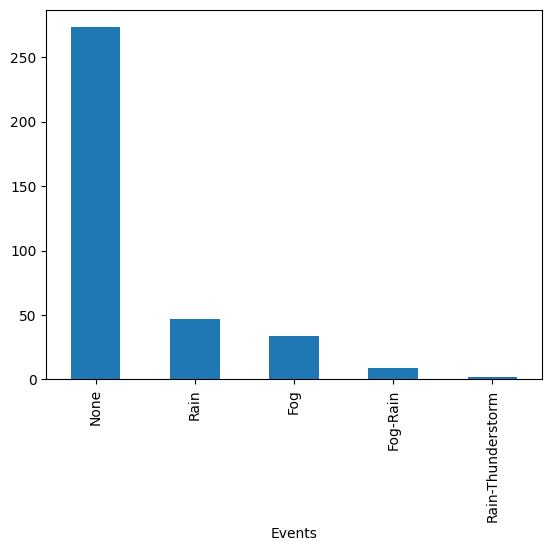

In [200]:
weather_data['Events'] = weather_data['Events'].fillna('None')
weather_data['Events'].value_counts().plot(kind='bar')

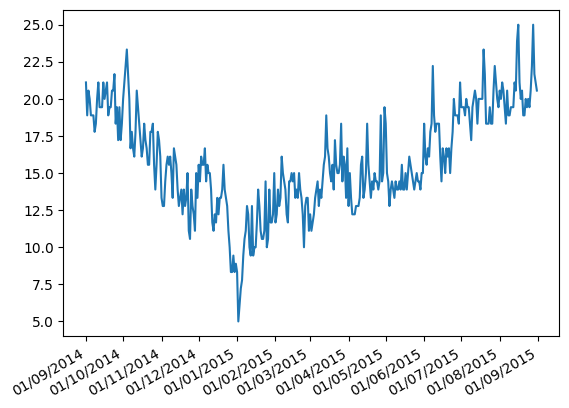

In [201]:
from matplotlib.dates import DateFormatter, MonthLocator

plt.plot(weather_data['Date'], weather_data['Mean TemperatureC'])
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=1))  # Show a subset of ticks for better readability
plt.gca().xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))  # Format as 'YYYY-MM-DD'

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()
plt.show()


## Data transformatie

Nu dat we een beter begrip hebben van de gegevens, is het tijd om de data klaar te maken voor een machine learning model. <br>
De data moet 2 onderdelen bevatten voor we ons model kunnen trainen. <br> 
1. Eerst moeten we een 'Target' hebben, de waarde die we willen voorspellen. In deze opdracht willen we ervoor zorgen dat op elk moment fietsen beschikbaar zijn voor de klanten. We weten niets over het absolute aantal fietsen op een station, dus deze waarde is moeilijk te voorspellen. Wat we wel weten is hoeveel fietsen aankomen en vertrekken op een bepaald station. Hierdoor kunnen we een netto 'verandering aan fietsen' berekenen en ook voorspellen. Deze verandering per uur bekijken lijkt een goeie target, per minuut is te ambitieus en geeft ook geen tijd voor de volgwagen om nieuwe fietsen te leveren waar nodig, en aangezien de meeste trips korter zijn dan één uur gaat per dag een te groot venster zijn. Plaatsen waar we grote veranderingen voorspellen kunnen we de volgauto naartoe sturen, om extra fietsen af/op te laden.<br>
2. Ten tweede hebben we features nodig die het model kan gebruiken om onze target te voorspellen. De exploratie die we juist gedaan hebben kan hiervoor nuttig zijn alsook onze eigen intuitie. We zagen bijvoorbeeld dat er 2 piek uren rond 8 en rond 17, het uur is dus een belangrijke feature om de 'verandering aan fietsen' te voorspellen. Andere gegevens zoals de dag van de week, de maand, welk station, het weer zijn allemaal zaken die invloed kunnen hebben op 'verandering aan fietsen'.

In [202]:
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,82,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,82,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,60,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,59,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,28,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


Dit is de data waar we mee zijn geeindigt na de voorgaande analyse. We kunnen deze eerst wat opschonen en de tripDuration, duration_bins en Start/End minuten verwijderen (We voorspellen per uur dus de minuten zijn niet meer nodig).

In [203]:
trip_data = trip_data.drop('tripDuration',axis=1)
trip_data = trip_data.drop('duration_bins',axis=1)
trip_data = trip_data.drop('StartMinute',axis=1)
trip_data = trip_data.drop('EndMinute',axis=1)
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,StartYear,StartMonth,StartDay,StartWeekday,StartHour,EndYear,EndMonth,EndDay,EndWeekday,EndHour
0,891070,82,42,Subscriber,2015,8,14,4,23,2015,8,14,4,23
1,891069,82,87,Subscriber,2015,8,14,4,23,2015,8,14,4,23
2,891068,60,74,Subscriber,2015,8,14,4,23,2015,8,14,4,23
3,891067,59,59,Subscriber,2015,8,14,4,23,2015,8,14,4,23
4,891066,28,27,Subscriber,2015,8,14,4,23,2015,8,14,4,23


Om de netto 'verandering in fietsen' op een bepaald station te voorspellen hebben we 2 onderdelen nodig, de fietsen die aankomen in dit station (End Station) en degene die vertrekken vanaf dit station (Start Station)

In [204]:
IncomingBikes = trip_data.groupby(['Start Station', 'StartYear','StartMonth','StartDay','StartHour']).size().reset_index(name='incoming')
IncomingBikes.head()


,Start Station,StartYear,StartMonth,StartDay,StartHour,incoming
0,2,2014,9,1,12,1
1,2,2014,9,1,21,4
2,2,2014,9,1,22,1
3,2,2014,9,2,1,1
4,2,2014,9,2,7,3


We weten niet of er op elk uur een fiets vertrekt of aankomt op een bepaald station. Dus we maken eerst een dataset aan die voor elk station alle uren bevat.

In [205]:
date_range = pd.date_range(start=minDate, end=maxDate, freq='H')
date_df = pd.DataFrame(date_range, columns=['datetime'])
date_df['dateIndex'] = range(len(date_df)) # We voegen een tijdsindex toe, deze gaat ons later helpen

stations_df = pd.DataFrame(trip_data['Start Station'].unique(), columns=['Station'])
stationTime_df = pd.merge(date_df,stations_df,how='cross')
stationTime_df['year'] = stationTime_df['datetime'].dt.year
stationTime_df['month'] = stationTime_df['datetime'].dt.month
stationTime_df['day'] = stationTime_df['datetime'].dt.day
stationTime_df['weekday'] = stationTime_df['datetime'].dt.weekday
stationTime_df['hour'] = stationTime_df['datetime'].dt.hour
stationTime_df= stationTime_df.drop('datetime',axis=1)
stationTime_df.head()

,dateIndex,Station,year,month,day,weekday,hour
0,0,82,2014,9,1,0,0
1,0,60,2014,9,1,0,0
2,0,59,2014,9,1,0,0
3,0,28,2014,9,1,0,0
4,0,50,2014,9,1,0,0


In [206]:
IncomingBikes = pd.merge(stationTime_df, IncomingBikes, left_on=['Station', 'year','month','day','hour'],right_on=['Start Station','StartYear','StartMonth','StartDay','StartHour'] , how='left')
IncomingBikes = IncomingBikes.drop(['Start Station','StartYear','StartMonth','StartDay','StartHour'],axis=1)
IncomingBikes['incoming'] = IncomingBikes['incoming'].fillna(0).astype(int)
IncomingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


In [207]:
OutGoingBikes = trip_data.groupby(['End Station', 'EndYear','EndMonth','EndDay','EndHour']).size().reset_index(name='outgoing')
OutGoingBikes.head()
OutGoingBikes = pd.merge(stationTime_df, OutGoingBikes, left_on=['Station', 'year','month','day','hour'],right_on=['End Station','EndYear','EndMonth','EndDay','EndHour'] , how='left')
OutGoingBikes = OutGoingBikes.drop(['End Station','EndYear','EndMonth','EndDay','EndHour'],axis=1)
OutGoingBikes['outgoing'] = OutGoingBikes['outgoing'].fillna(0).astype(int)
OutGoingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,outgoing
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


In [208]:
ChangeInBikes = pd.merge(IncomingBikes,OutGoingBikes,on=['dateIndex','Station','year','month','day','hour','weekday'],how= 'left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


In [209]:
ChangeInBikes['netBikeChange'] = ChangeInBikes['incoming'] - ChangeInBikes['outgoing']
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing,netBikeChange
0,0,82,2014,9,1,0,0,0,0,0
1,0,60,2014,9,1,0,0,0,0,0
2,0,59,2014,9,1,0,0,0,0,0
3,0,28,2014,9,1,0,0,0,0,0
4,0,50,2014,9,1,0,0,0,0,0


NetBikeChange is onze target value en dus de waarde die we willen voorspellen, de overige kolommen zijn al enkele features die we kunnen gebruiken om de voorspelling te maken. Natuurlijk de incoming en outgoing waardes zijn onbekend tijdens het voorspellen, dus die verwijderen we nog eerst.

In [210]:
ChangeInBikes= ChangeInBikes.drop(['incoming','outgoing'],axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


Nu kunnen we even nadenken welke andere features nog van pas zouden komen.
- Het aantal fiestenstalling in een station
- de Stad waarin het station zich bevindt
- Is het weekend?
- Weer events (regen,mist,...)
- Temperatuur

In [211]:
ChangeInBikes['IsWeekend'] = ChangeInBikes['weekday'].isin([5, 6]).astype(int)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


In [212]:
ChangeInBikes = pd.merge(ChangeInBikes, station_data, left_on='Station', right_on='Id',how='left')
ChangeInBikes = ChangeInBikes.drop(['Id','Name','Lat','Long'],axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City
0,0,82,2014,9,1,0,0,0,0,15,San Francisco
1,0,60,2014,9,1,0,0,0,0,15,San Francisco
2,0,59,2014,9,1,0,0,0,0,23,San Francisco
3,0,28,2014,9,1,0,0,0,0,23,Mountain View
4,0,50,2014,9,1,0,0,0,0,23,San Francisco


We kunnen de stad niet zomaar gebruiken, niet alle modellen kunnen werken met categorie waarden. We zullen deze eerst veranderen via one-hot encoding.

In [213]:
ChangeInBikes['City'] = ChangeInBikes['City'].str.replace(' ','_')
citiesEncoded = pd.get_dummies(ChangeInBikes['City'], prefix='City')
ChangeInBikes = pd.concat([ChangeInBikes, citiesEncoded], axis=1)
ChangeInBikes= ChangeInBikes.drop('City',axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose
0,0,82,2014,9,1,0,0,0,0,15,False,False,False,True,False
1,0,60,2014,9,1,0,0,0,0,15,False,False,False,True,False
2,0,59,2014,9,1,0,0,0,0,23,False,False,False,True,False
3,0,28,2014,9,1,0,0,0,0,23,True,False,False,False,False
4,0,50,2014,9,1,0,0,0,0,23,False,False,False,True,False


Voor we de 2 features over het weer kunnen toevoegen moeten we de datums van de weer tabel aanpassen. Beide datums moeten in dezelfde vorm staan zodat we de tabellen kunnen verbinden.

In [214]:
weather_data['year'] = weather_data['Date'].dt.year
weather_data['month'] = weather_data['Date'].dt.month
weather_data['day'] = weather_data['Date'].dt.day
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,Mean TemperatureC,year,month,day
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,20.0,0.0,0.0,None,290.0,94107,21.11,2014,9,1
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,NaN,0.0,5.0,None,290.0,94107,18.89,2014,9,2
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,24.0,0.0,4.0,None,276.0,94107,20.56,2014,9,3
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,25.0,0.0,5.0,None,301.0,94107,20.00,2014,9,4
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,32.0,0.0,4.0,None,309.0,94107,18.89,2014,9,5


In [215]:
weather_data_features = weather_data[['year','month','day','Mean TemperatureC','Events']]
weather_data_features.head()

,year,month,day,Mean TemperatureC,Events
0,2014,9,1,21.11,None
1,2014,9,2,18.89,None
2,2014,9,3,20.56,None
3,2014,9,4,20.00,None
4,2014,9,5,18.89,None


In [216]:
weather_data_features['Events'] = weather_data_features['Events'].str.replace(' ','_')
weatherEncoded = pd.get_dummies(weather_data_features['Events'], prefix='Event')
weather_data_features = pd.concat([weather_data_features, weatherEncoded], axis=1)
weather_data_features= weather_data_features.drop('Events',axis=1)
weather_data_features.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,month,day,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,2014,9,1,21.11,False,False,True,False,False
1,2014,9,2,18.89,False,False,True,False,False
2,2014,9,3,20.56,False,False,True,False,False
3,2014,9,4,20.00,False,False,True,False,False
4,2014,9,5,18.89,False,False,True,False,False


In [217]:
ChangeInBikes = pd.merge(ChangeInBikes, weather_data_features, on=['year','month','day'],how='left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,0,82,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
1,0,60,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
2,0,59,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,False,False,21.11,False,False,True,False,False
4,0,50,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False


Een volgend feature dat kan helpen, is een zeer populaire bij het voorspellen van waarden over tijd (Time series predictions). Namelijk de waarde van het vorige uur (of van de vorige uren). Als we terugdenken aan onze piek uren, herinneren we ons dat drukke periodes niet plots opdaagden, maar geleidelijk op en afbouwt. 

Hier komt de tijdsindex terug van pas

In [218]:
def getNetChangeFromPreviousHour(df,dateIndex,station,n=1):
    if (dateIndex-n) > 0:
        prevNetChange = df.loc[(df['dateIndex'] == dateIndex-n) & (df['Station'] == station), 'netBikeChange'].values[0]
    else:
        prevNetChange = 0
    return prevNetChange

Dit zijn zwaardere functies aangezien we over elke rij moeten gaan en vervolgens voor elke rij de vorige waardes opzoeken in de tabel. Daarom is er ook een bestandje toegevoegd dat de nodige waardes al bevat. Door deze te linken aan onze tabel kunnen we wat tijd besparen.

In [219]:
#ChangeInBikes['NetBikeChange-1'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station']), axis=1)
#ChangeInBikes['NetBikeChange-2'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station'],2), axis=1)

De volgende functie laad het bestand in en voegt de waardes toe aan de feature tabel.

In [220]:
previousValues = pd.read_csv("../data/previousValues.csv")
ChangeInBikes = pd.merge(ChangeInBikes, previousValues, on=['dateIndex','Station'],how='left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,0,82,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
1,0,60,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
2,0,59,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,21.11,False,False,True,False,False,0,0
4,0,50,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0


Hier voegen we de veranderingen tijdens de vorige 2 uren toe, we kunnen nog meer van deze historische waardes toevoegen, maar we telkens het nut hiervan afwegen. Elk feature dat we toevoegen maakt ons model iets zwaarder, met deze vroegere waarden moeten we ook naar hun relevantie kijken. Hoeveel fietsen er 5 uur geleden zijn bijgekomen gaat weinig tot geen invloed hebben op hoeveel fietsen we nu gaan zien aankomen.<br><br>
Voor dit deel afmaken verwijderen we nog even de 'dateIndex', deze was handig voor de vorige waardes toe te voegen maar heeft nu geen nut meer.

In [221]:
ChangeInBikes = ChangeInBikes.drop('dateIndex',axis=1)
ChangeInBikes.head()

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,82,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
1,60,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
2,59,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0
3,28,2014,9,1,0,0,0,0,23,True,...,False,False,21.11,False,False,True,False,False,0,0
4,50,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0


We hebben nu al een mooi nummer aan features die ons model kan gebruiken, voor het voorspellen van de verandering aan fietsen. Laten we nu eens kijken hoe we deze data aan een model kunnen aanbieden.

# Model trainen

Voor we kunnen beginnen modelleren en voorspellingen maken, moeten we de data nog één keer aanpassen. We moeten hem eerst opsplitsen in 2 groepen:<br>
De Trainingsdata, die we gebruiken om onze modellen te leren hoe ze onze targetwaarde kunnen voorspellen. Dit is meestal ook het grootste deel van de data, zodat het model betere predicties kan maken.<br>
De test data, deze wordt apart gehouden tot het einde om te controleren hoe goed ons model werkt op ongeziene data.<br>
Vaak is er nog een derde categorie, de validatie data, deze helpt om bepaalde parameters voor de modellen te kiezen. Vandaag gaan we geen extra parameters afwegen dus we kunnen deze data gebruiken om een grondigere eindevaluatie te voeren.<br><br>
Hoeveel data we gebruiken voor elke groep, moeten we zelf afwegen. Een vuistregel is 80/10/10, 80% van de data voor training, 10% voor validatie en 10% voor het testen.<br>
Vaak delen we de dataset quasi willekeurig op in de verschillende groepen, op deze manier voorkomen we dat er bijvoorbeeld nooit regen gezien werd in de trainingsdata. Maar in tijdserie voorspellingen, zoals de data waar we momenteel mee bezig zijn, wordt er vaak gesplitst op een bepaalde datum aangezien dit beter de realiteit reflecteert.


In dit geval hebben we bijna een jaar aan data, laten we de eerste 9 maanden gebruiken om te trainen en de overige 2,5 om te testen. Dit zou betekenen dat we splitsen vanaf 1 juni. Alles ervoor is onze training set, alles erna is onze test set

In [222]:
training_df = ChangeInBikes[(ChangeInBikes['year']==2014) | (ChangeInBikes['month']< 6)]
training_df

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,82,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
1,60,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
2,59,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0
3,28,2014,9,1,0,0,0,0,23,True,...,False,False,21.11,False,False,True,False,False,0,0
4,50,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497947,69,2015,5,31,6,23,0,1,23,False,...,True,False,15.00,False,False,True,False,False,0,0
497948,72,2015,5,31,6,23,0,1,23,False,...,True,False,15.00,False,False,True,False,False,0,0
497949,49,2015,5,31,6,23,0,1,19,False,...,True,False,15.00,False,False,True,False,False,0,0
497950,23,2015,5,31,6,23,0,1,15,False,...,False,False,15.00,False,False,True,False,False,0,0


In [223]:
test_df =  ChangeInBikes[(ChangeInBikes['year']==2015) & (ChangeInBikes['month']>= 6)]
test_df

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
497952,82,2015,6,1,0,0,0,0,15,False,...,True,False,18.33,False,False,False,True,False,0,-1
497953,60,2015,6,1,0,0,0,0,15,False,...,True,False,18.33,False,False,False,True,False,0,2
497954,59,2015,6,1,0,0,0,0,23,False,...,True,False,18.33,False,False,False,True,False,0,0
497955,28,2015,6,1,0,0,0,0,23,True,...,False,False,18.33,False,False,False,True,False,0,0
497956,50,2015,6,1,0,0,0,0,23,False,...,True,False,18.33,False,False,False,True,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634747,69,2015,8,14,4,23,0,0,23,False,...,True,False,20.56,False,False,True,False,False,0,0
634748,72,2015,8,14,4,23,0,0,23,False,...,True,False,20.56,False,False,True,False,False,0,0
634749,49,2015,8,14,4,23,0,0,19,False,...,True,False,20.56,False,False,True,False,False,0,0
634750,23,2015,8,14,4,23,0,0,15,False,...,False,False,20.56,False,False,True,False,False,0,0


### Eerste wiskundige versie

Een goede tip tijdens het trainen van machine learning modellen is om te beginnen met een zeer simpele versie. Deze hoeft niet eens gebruik te maken van machine learning en kan gewoon wiskundig zijn. Op deze manier hebben we een basis, waartegen we de meer geavanceerde versies kunnen vergelijken.<br>
In dit geval zou zo een basis bijvoorbeeld kunnen zijn om de gemiddelde 'verandering aan fietsen' te berekenen en altijd deze te voorspellen.<br>
Wij gaan voor een iets geavanceerdere versie gaan. Aangezien we de 'verandering aan fietsen' gedurende de vorige 2 momenten hebben, kunnen we de vorige veranderingen berekenen en deze verder zetten tijdens het volgende uur.



In [224]:
def derivativePrediction(lastHour,twoHoursAgo):
    return lastHour + (lastHour-twoHoursAgo) 

In [225]:
test_deriv_df = test_df.copy()
test_deriv_df['predicted'] = test_df.apply(lambda row: derivativePrediction(row['NetBikeChange-1'], row['NetBikeChange-2']), axis=1)
test_deriv_df.head()

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2,predicted
497952,82,2015,6,1,0,0,0,0,15,False,...,False,18.33,False,False,False,True,False,0,-1,1
497953,60,2015,6,1,0,0,0,0,15,False,...,False,18.33,False,False,False,True,False,0,2,-2
497954,59,2015,6,1,0,0,0,0,23,False,...,False,18.33,False,False,False,True,False,0,0,0
497955,28,2015,6,1,0,0,0,0,23,True,...,False,18.33,False,False,False,True,False,0,0,0
497956,50,2015,6,1,0,0,0,0,23,False,...,False,18.33,False,False,False,True,False,0,0,0


In [226]:
from sklearn.metrics import mean_squared_error

test_MSE = mean_squared_error(test_deriv_df['netBikeChange'],test_deriv_df['predicted'])
print(f"baseline: de MSE error op de test set is: {test_MSE}")

baseline: de MSE error op de test set is: 9.960182748538012


Deze mean square error geeft aan hoeveel fietsen we gemiddeld naast de eigenlijke verandering zitten. Deze baseline geeft aan dat we gemiddeld rond de 10 fietsen fout zitten. Dit is natuurlijk geen geweldig resultaat dus hopelijk kan een machine learning model dit beter dan een simpel wiskundig model.

## Lineaire regressie

Voor we de eigenlijke training doen, moeten we de dataset in een vorm brengen die geaccepteerd wordt door de gebruikte functies. In dit geval maken we gebruik van de [scikit-learn library](https://scikit-learn.org/stable/modules/classes.html), In de documentatie vinden we dat modellen op de volgende manier getraind worden:<br><br>
<em> model = LinearRegression().fit(X, y)</em><br><br>
Hier staat X voor onze features en y voor onze targetwaarde, dus we moeten eerst onze train en test set splitsen.

In [227]:
train_target = training_df['netBikeChange']
train_df_features = training_df.drop('netBikeChange',axis=1)

test_target = test_df['netBikeChange']
test_df_features = test_df.drop('netBikeChange',axis=1)

Ons eerste model is een lineaire regressie, deze zal proberen de target waarde te voorspellen als een lineaire combinatie van de verschillende features.

In [228]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_df_features, train_target)

predictions= lr.predict(test_df_features)
lr_test_MSE = mean_squared_error(test_target,predictions)
print(f"linear regressor: de MSE error op de test set is: {lr_test_MSE}")

linear regressor: de MSE error op de test set is: 2.5316496756037683

We hebben zojuist ons eerste machine learning model kunnen trainen in slechts 2 lijnen code! <br>
Deze is al een verbetering ten opzichte van onze baseline, de gemiddelde fout hebben we kunnen verlagen van 10 fietsen naar 2.5 fietsen.<br>

### Feature importance
Nu we een getraind model hebben kunnen we ook eens kijken welke van onze features het belangrijkste zijn tijdens onze voorspellingen.
Aangezien lineaire regressie gewoon een lineaire combinatie is van onze features kunnen we hun belang vinden gewoon door te kijken naar hun gewichten, hoe groter deze waarde hoe belangrijker de feature.

In [229]:
coefficients = lr.coef_
sorted_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in sorted_features:
    print(f'{feature}: {coefficient}')


Feature Coefficients:
Event_Fog: 20857722070.537483
Event_Fog-Rain: 20857722070.5371
Event_None: 20857722070.53676
Event_Rain: 20857722070.536503
Event_Rain-Thunderstorm: 20857722070.533356
NetBikeChange-1: 0.3439436090425055
NetBikeChange-2: 0.006298652555291282
Station: 0.00022552005332838418
IsWeekend: 6.679826813759449e-05
weekday: 6.669070091550493e-05
Mean TemperatureC: 3.8153219466339333e-05
day: 2.596955755554887e-06
month: -7.38231039306339e-05
year: -0.00010742067592796768
hour: -0.0014277016479333532
Dock Count: -0.0015986499765672582
City_San_Jose: -122354646768.81856
City_Mountain_View: -122354646768.82082
City_San_Francisco: -122354646768.82193
City_Palo_Alto: -122354646768.824
City_Redwood_City: -122354646768.8266


In [230]:
def featureImportanceGraph(importanceZip):
    sorted_features = sorted(importanceZip, key=lambda x: x[1], reverse=True)
    features, importance_values=  zip(*sorted_features)
    plt.bar(features, importance_values, color='blue')
    plt.xlabel('Features')
    plt.xticks(features, rotation= 90)
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()

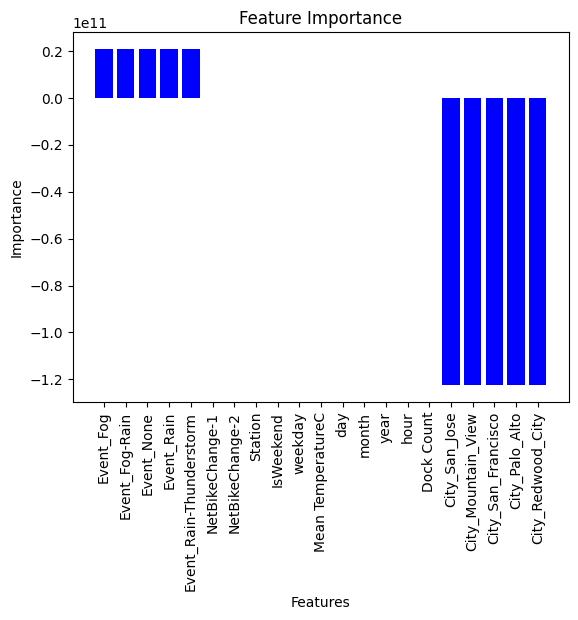

In [231]:
featureImportanceGraph(sorted_features)

Als we de coeficcienten extraheren krijgen we een globaal overzicht op het belang van de verschillende features. Via SHAP kunnen we inzoomen en de contributie van de features binnen één voorbeeld bekijken. 

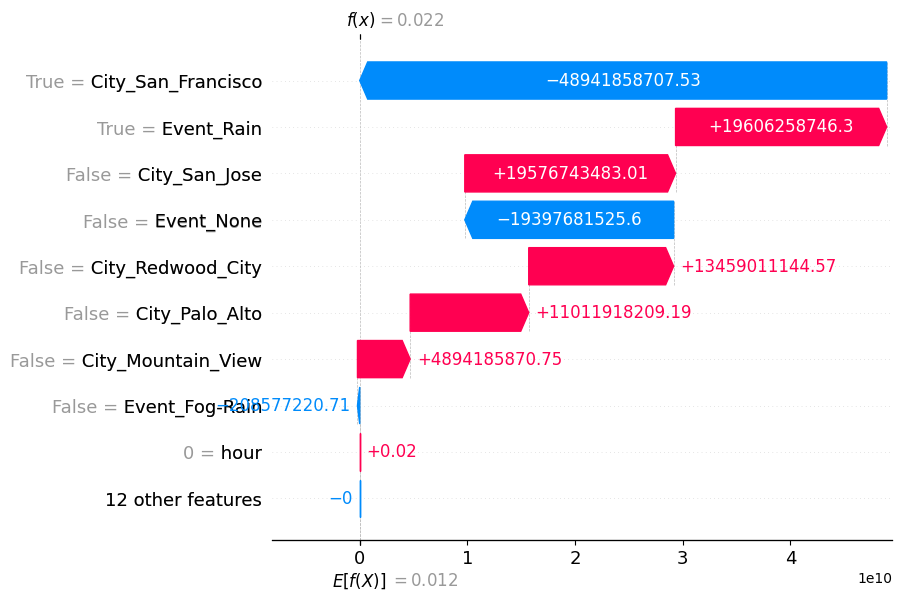

In [232]:
explainer = shap.Explainer(lr, test_df_features)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])


## Laten we nog wat andere modellen proberen

### Ridge regression

Het volgende model dat we proberen is een variatie op lineaire regressie, namelijk Ridge regressie. Ze werken op een gelijkaardige manier, het verschil is dat Ridge regressie een regularisatie term toevoegt. Deze probeert de verschillende gewichten zo klein mogelijk te houden, wat van pas komt gezien de vorige resultaten. Voor deze regularisatie term is een hyperparameter alpha nodig, deze weegt af tussen de gewichten zo klein mogelijk houden en een accuraat model.<br>

De CV (in RidgeCV) staat voor cross-validatie, dit model kiest volgens deze techniek de beste alpha waarde uit een reeks die wij meegeven zonder dat wij een validatie dataset moeten meegeven.


ridge regressor: de MSE error op de test set is: 2.5316238028243507
Feature Coefficients:
NetBikeChange-1: 0.343912575891785
NetBikeChange-2: 0.006277851904580838
City_San_Jose: 0.0027239880654453814
City_Mountain_View: 0.001693794387280709
Event_Fog-Rain: 0.001013074613517866
Event_Rain: 0.0006026793750435813
Event_None: 0.000442575390838093
Event_Fog: 0.00031027941611415724
City_San_Francisco: 0.00029773586105351867
Station: 0.00015024525749313372
weekday: 6.687673550904107e-06
day: -2.3972801083384123e-06
Mean TemperatureC: -3.912383027276523e-06
month: -3.820909157729309e-05
IsWeekend: -0.00015484608348106339
year: -0.00022238655812714385
hour: -0.0014233645276634233
Dock Count: -0.0015706281822850305
City_Redwood_City: -0.0017527532320256174
Event_Rain-Thunderstorm: -0.0023686053036136292
City_Palo_Alto: -0.002962783645348323


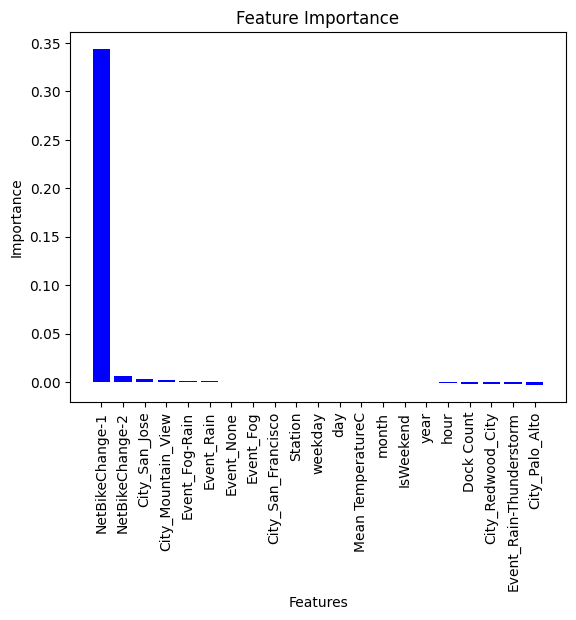

In [233]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(train_df_features, train_target)
predictions= ridge.predict(test_df_features)
ridge_test_MSE = mean_squared_error(test_target,predictions)
print(f"ridge regressor: de MSE error op de test set is: {ridge_test_MSE}")

coefficients = ridge.coef_
ridge_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in ridge_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ridge_features)

ridgeCV regressor: de MSE error op de test set is: 2.531636436023509
Feature Coefficients:
NetBikeChange-1: 0.34290630985672443
NetBikeChange-2: 0.00660904364828685
City_San_Jose: 0.0025906099811481703
City_Mountain_View: 0.001545550259069689
Event_Fog-Rain: 0.0005622869203993353
City_San_Francisco: 0.0002830845411840588
Event_Rain: 0.0002672162508336462
Station: 0.0001491410363172463
Event_None: 0.0001288329177081965
weekday: 9.059118843773861e-06
Event_Fog: 4.892415570056929e-06
Mean TemperatureC: -2.0548135322706607e-06
day: -3.3827954707410512e-06
month: -2.6206168031395194e-05
year: -0.00014523255319706663
IsWeekend: -0.00018114954804399064
Event_Rain-Thunderstorm: -0.0009632285045107539
hour: -0.0014246244339410907
Dock Count: -0.001568443178037282
City_Redwood_City: -0.0016877071768319866
City_Palo_Alto: -0.0027315376045694006


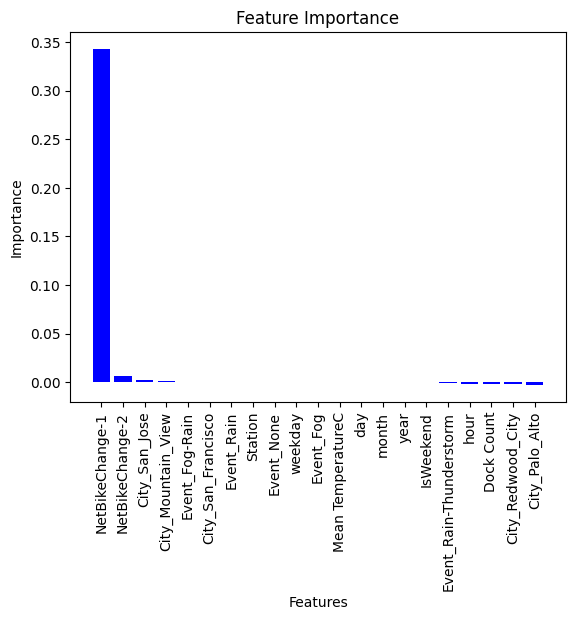

In [234]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-6, 6, 25)
ridgeCV = RidgeCV(alphas=alphas)
ridgeCV.fit(train_df_features, train_target)
predictions= ridgeCV.predict(test_df_features)
ridge_test_MSE = mean_squared_error(test_target,predictions)
print(f"ridgeCV regressor: de MSE error op de test set is: {ridge_test_MSE}")

coefficients = ridgeCV.coef_
ridgeCV_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in ridgeCV_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ridgeCV_features)

Ondanks dat we geen verbetering merken op de test mean squared error in vergelijking met de gewone lineaire regressie, zijn de gewichten van de verschillende features nu overzichtelijker (zonder extreem grote waardes). Hierdoor krijgen we een beter overzicht welke nu van belang zijn.

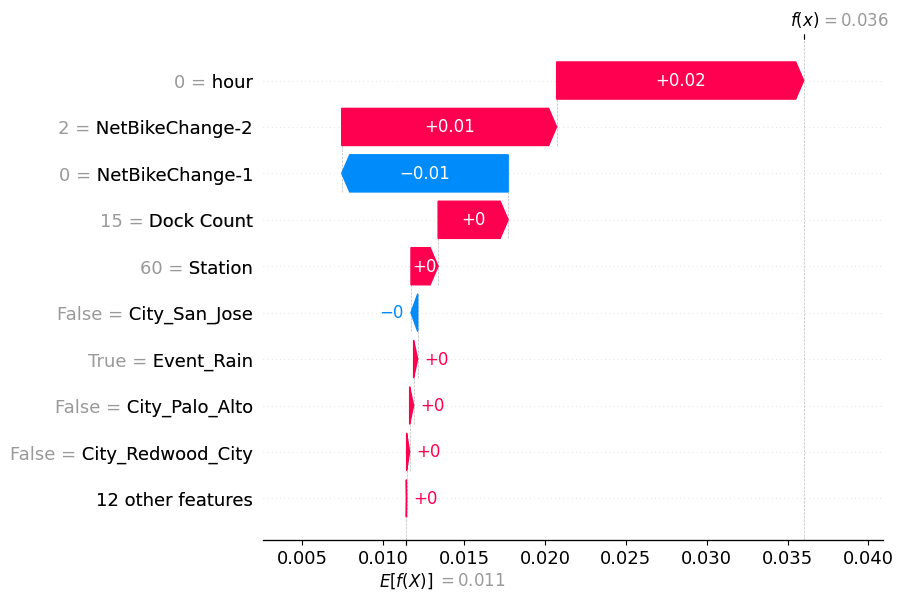

In [235]:
explainer = shap.Explainer(ridgeCV, test_df_features)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[1])


### Decision tree

Vervolgens kunnen we ook even kijken naar beslissingsbomen (decision trees), deze werken aan de hand van slimme vragen over de features die de data telkens opdeelt in 2 delen. De voorspelling is afhankelijk van het eindpunt waar we op belanden na het beantwoorden van alle vragen.<br><br>
Een belangrijke parameter hier is de diepte van de boom, dit vertelt hoeveel vragen we moeten beantwoorden voor we een antwoord krijgen.<br> 
Experimenteer maar even met deze diepte en kijk naar het effect op MSE (normale dieptes zitten tussen de 1 en 10). Het is ook mogelijk om de boom uiteindelijk te plotten via de plot_tree functie

Decision tree: de MSE error op de test set is: 1.920527456123344
Feature Coefficients:
NetBikeChange-1: 0.3545260186129897
hour: 0.30080410861908646
Station: 0.2035698004983301
Dock Count: 0.06276124506090916
NetBikeChange-2: 0.02276161349338858
weekday: 0.012498468091769122
IsWeekend: 0.011196187170302924
day: 0.009332359215026152
Mean TemperatureC: 0.006865779853359014
month: 0.006526305619675147
City_San_Francisco: 0.0035626024307917775
year: 0.0019852410390901933
Event_Fog: 0.0016331904646830558
Event_None: 0.0013663274454678406
Event_Rain: 0.00023635159822268522
City_Mountain_View: 0.00020054823337435472
Event_Fog-Rain: 0.00014519880406011317
City_San_Jose: 2.8653749473580204e-05
City_Palo_Alto: 0.0
City_Redwood_City: 0.0
Event_Rain-Thunderstorm: 0.0


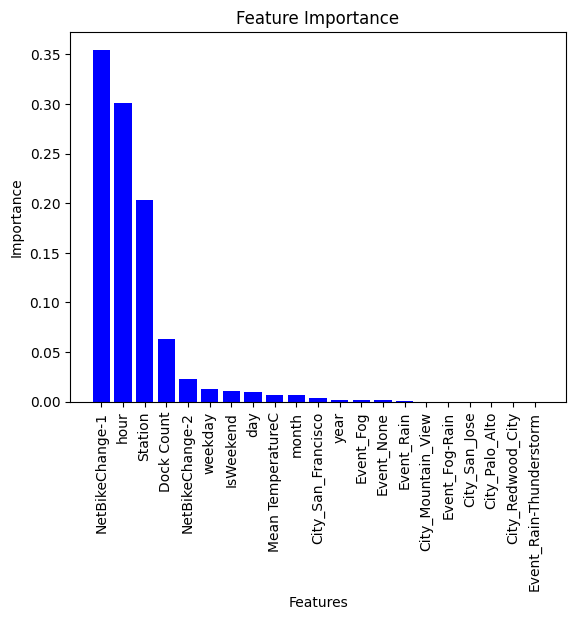

In [236]:
from sklearn import tree

decTree = tree.DecisionTreeRegressor(max_depth=10) 
decTree.fit(train_df_features, train_target)
predictions= decTree.predict(test_df_features)
decTree_test_MSE = mean_squared_error(test_target,predictions)
print(f"Decision tree: de MSE error op de test set is: {decTree_test_MSE}")

feature_importances = decTree.feature_importances_
tree_features = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in tree_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(tree_features)

[Text(0.3231591921119593, 0.9545454545454546, 'x[19] <= -16.5\nsquared_error = 2.442\nsamples = 497952\nvalue = 0.0'),
 Text(0.07423664122137405, 0.8636363636363636, 'x[5] <= 17.5\nsquared_error = 140.0\nsamples = 369\nvalue = -15.103'),
 Text(0.023377862595419848, 0.7727272727272727, 'x[0] <= 67.5\nsquared_error = 79.134\nsamples = 131\nvalue = -26.534'),
 Text(0.015076335877862595, 0.6818181818181818, 'x[20] <= -1.5\nsquared_error = 8.0\nsamples = 3\nvalue = -3.0'),
 Text(0.01405852417302799, 0.5909090909090909, 'squared_error = 0.0\nsamples = 2\nvalue = -1.0'),
 Text(0.016094147582697203, 0.5909090909090909, 'squared_error = 0.0\nsamples = 1\nvalue = -7.0'),
 Text(0.0316793893129771, 0.6818181818181818, 'x[13] <= 16.39\nsquared_error = 67.516\nsamples = 128\nvalue = -27.086'),
 Text(0.01812977099236641, 0.5909090909090909, 'x[20] <= -0.5\nsquared_error = 53.824\nsamples = 91\nvalue = -25.407'),
 Text(0.010814249363867684, 0.5, 'x[4] <= 3.5\nsquared_error = 48.947\nsamples = 84\nvalu

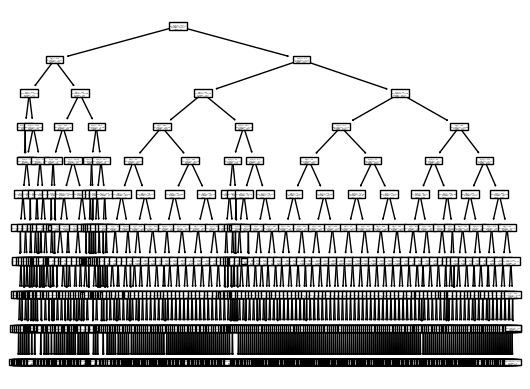

In [237]:
tree.plot_tree(decTree)

Bij een diepte van 10 zien we al een verbetering in de MSE van 2.5 naar minder dan 2 fietsen. We hebben dus een nieuwe beste versie gevonden! Het plotten van de boom is echter wel onoverzichtelijk geworden.<br>
De belangrijkste features waren uiteindelijk:  de 'verandering van fietsen' tijdens het vorige uur, het uur van de dag, het station en het aantal plaatsen voor fietsen.

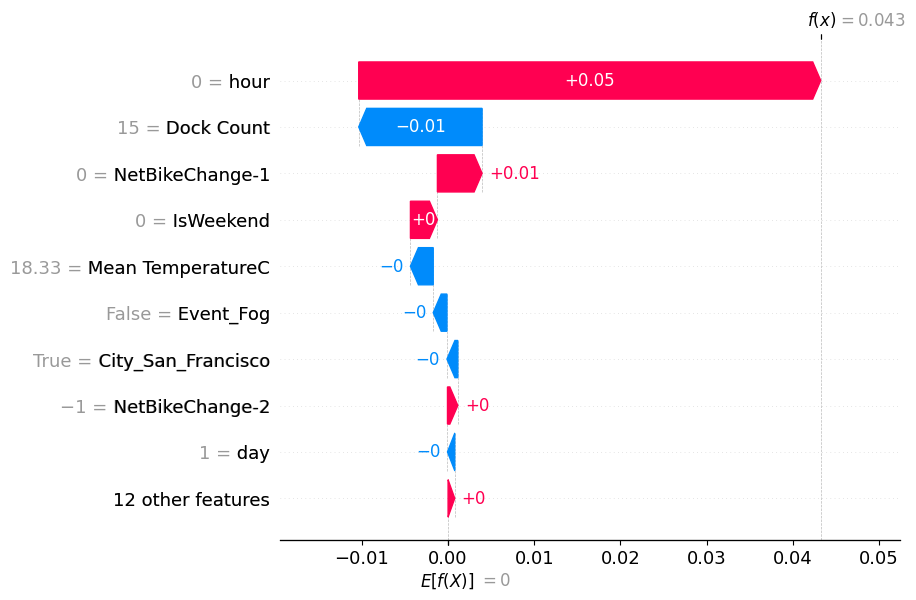

In [238]:
explainer = shap.TreeExplainer(decTree)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])

### Random Forest

Het volgende model dat we gaan uittesten is een random forest regressor. Dit is een ensemble van decision trees (meerdere decision trees), waarbij de resultaten van elke tree samen worden gebracht om het uiteindelijke resultaat te verkrijgen.

Random forest: de MSE error op de test set is: 1.9246204928386685
Feature Coefficients:
NetBikeChange-1: 0.42990147145858676
hour: 0.3164012274092206
Station: 0.16066902090856786
Dock Count: 0.039208396005511584
NetBikeChange-2: 0.020678626667039075
weekday: 0.00891496928199628
Mean TemperatureC: 0.007734479398313165
month: 0.005687179730562673
day: 0.00520172554642458
year: 0.0019457332134139415
IsWeekend: 0.0019203425142985664
Event_Fog: 0.00044660325722699676
Event_None: 0.0003847104167901076
City_San_Francisco: 0.0003503303615340773
Event_Rain: 0.0003428456032057657
Event_Fog-Rain: 0.00014153477320387077
City_San_Jose: 4.9527102194642114e-05
City_Mountain_View: 2.1276351909455428e-05
City_Palo_Alto: 0.0
City_Redwood_City: 0.0
Event_Rain-Thunderstorm: 0.0


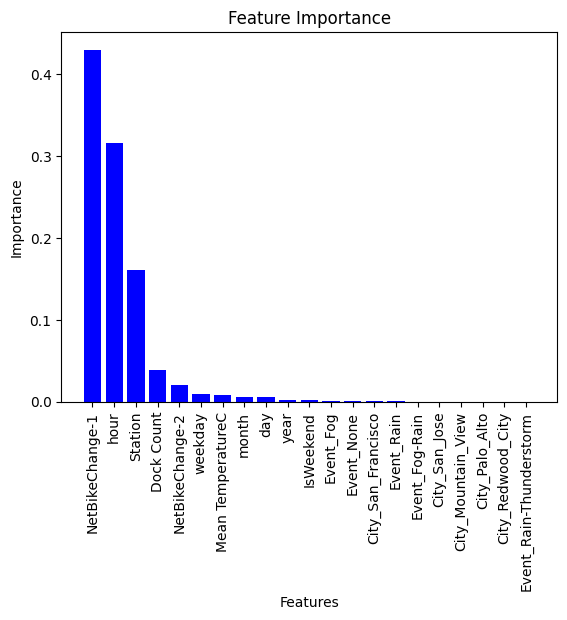

In [239]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(max_depth=8, n_estimators=25) 
rf.fit(train_df_features, train_target)
predictions= rf.predict(test_df_features)
rf_test_MSE = mean_squared_error(test_target,predictions)
print(f"Random forest: de MSE error op de test set is: {rf_test_MSE}")

feature_importances = rf.feature_importances_
rf_features = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in rf_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(rf_features)

Ondanks dat we werken met 24 extra decision trees blijft de performantie op de testset hetzelfde als die met slechts 1 boom. Dit is dus geen goeie keuze voor ons uiteindelijk model.<br>
We zien ook terug dezelfde meest belangrijke features 

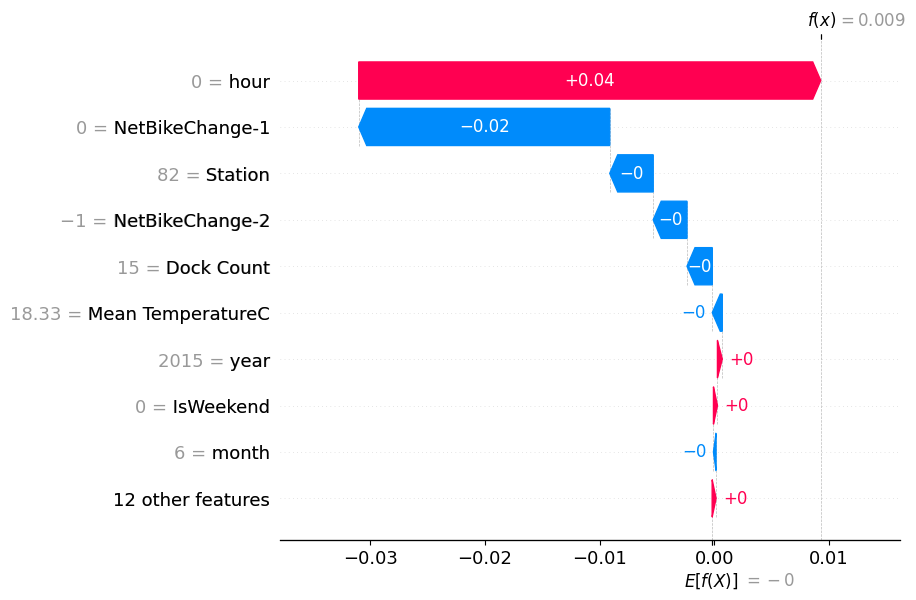

In [240]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])

### Gradient boosting

Vervolgens kunnen we kijken naar een gradient boost variant. Opnieuw een ensemble van beslissingsbomen zoals random forest, maar hier stemmen de verschillende bomen niet op het eindresultaat. Bij gradient boosting probeert elke boom de fouten van de vorige boom te corrigeren. We krijgen dus een serie van beslissingsbomen
Normale gradient boost modellen bevatten ingebouwde functies om het belang van de features te bekijken, maar dit is niet het geval bij de histogram versie. We zullen deze dus opnieuw berekenen aan de hand van permutaties. Een alternatieve manier om de belangen te berekenen. We veranderen telkens de waardes van 1 feature en controleren de invloed op de performantie, hoe groter de invloed hoe belangrijker de feature.<br>


GradientBoosting ensamble: de MSE error op de test set is: 1.6390974090630395
hour: 0.4588612745749021
NetBikeChange-1: 0.38276382441306317
Station: 0.21653755598379018
Dock Count: 0.08763834188310511
weekday: 0.04187631616500076
NetBikeChange-2: 0.014727985065072401
City_San_Francisco: 0.008101159819653559
IsWeekend: 0.00017969337373973103
day: 0.00016347932474405357
City_San_Jose: 5.341097634148362e-05
City_Mountain_View: 3.059678605707994e-05
Event_Rain: 9.713352113327467e-06
year: 0.0
City_Redwood_City: 0.0
Event_Fog: 0.0
Event_Fog-Rain: 0.0
Event_Rain-Thunderstorm: 0.0
City_Palo_Alto: -2.53777227988472e-05
month: -7.036449226005548e-05
Event_None: -0.00014139467764244794
Mean TemperatureC: -0.00044267987990331825


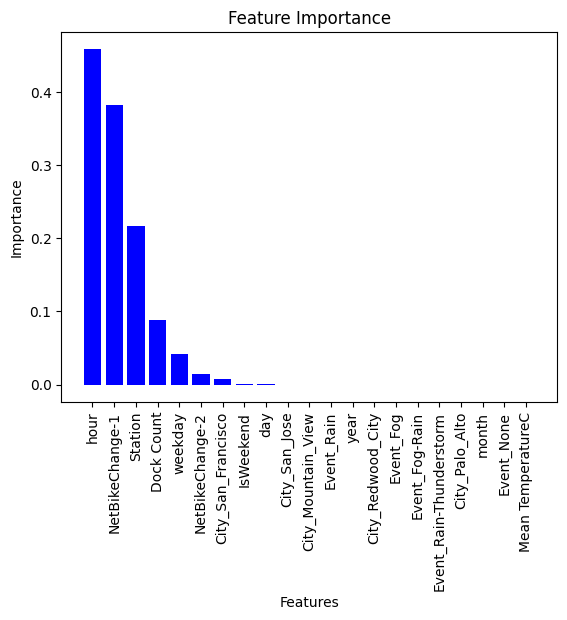

In [241]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

ensambleTree = HistGradientBoostingRegressor()
ensambleTree.fit(train_df_features, train_target)
predictions= ensambleTree.predict(test_df_features)
tree_test_MSE = mean_squared_error(test_target,predictions)
print(f"GradientBoosting ensamble: de MSE error op de test set is: {tree_test_MSE}")

# Een alternatieve manier om het belang van de features te berekenen
result = permutation_importance(ensambleTree, test_df_features, test_target, n_repeats=5, random_state=42)
feature_importances = result.importances_mean
ensambleTreeFeatures = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, coefficient in ensambleTreeFeatures:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ensambleTreeFeatures)

Dit model is een verbetering ten opzichte van de vorige, we krijgen nu een gemiddelde fout van 1.6 fietsen!<br>
Er wordt hier ook gebruikgemaakt van verschillende features om het eindresultaat te bekomen, de belangrijkste zijn het uur van de dag, de verandering van fietsen vorig uur en het station zelf.

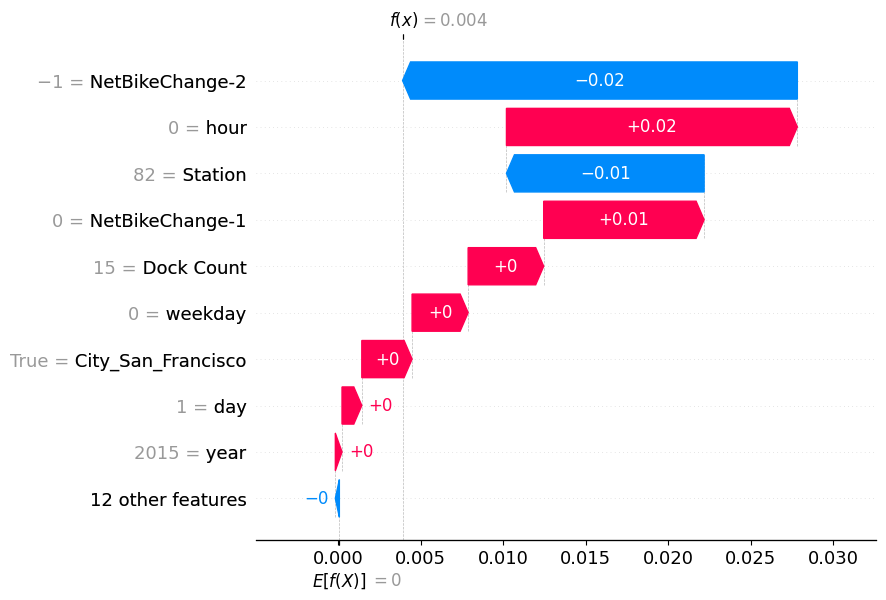

In [242]:
explainer = shap.TreeExplainer(ensambleTree)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])


### Multilayer perceptron

We hebben nu al 2 lineaire modellen en 3 beslissingsbomen getraind. Laten we dan eens kijken naar wat complexere modellen, zoals een neuraal netwerk.Meer specifiek een multilayer perceptron (MLP), MLP betekent gewoon verschillende lagen aan neuronen (of perceptrons) en is de simpelste variant van een neuraal netwerk.<br>
De output van iedere neuron is de lineaire combinatie van de outputs van de vorige laag, we voegen non-lineariteit toe door middel van een activatiefunctie toe te passen op de neuron outputs.<br><br>
Dit complexere model geeft meer flexibiliteit maar maakt het ook moeilijker om het belang van de verschillende features te vinden (black box). 

Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.


Multilayer perceptron: de MSE error op de test set is: 2.5434837022932064
NetBikeChange-1: 0.22300755241847492
City_San_Francisco: 0.0008002908055700697
hour: 0.0007907206375443066
City_San_Jose: 0.00033813477873421147
Dock Count: 0.0002688369734081819
City_Redwood_City: 0.00018361627675549385
City_Mountain_View: 0.00017706610079424313
IsWeekend: 0.00013140894580767614
City_Palo_Alto: 7.593498325821901e-05
Station: 2.6233486859905673e-05
Event_Fog-Rain: 7.803821731267035e-07
year: 0.0
Event_Fog: 0.0
Event_Rain: -1.851089779147941e-06
Event_None: -4.274661950787184e-06
weekday: -7.987667318354319e-06
Event_Rain-Thunderstorm: -8.26649979979166e-06
Mean TemperatureC: -1.641540066903424e-05
month: -2.8441446848148643e-05
day: -7.117769418456543e-05
NetBikeChange-2: -0.00031821160444303056


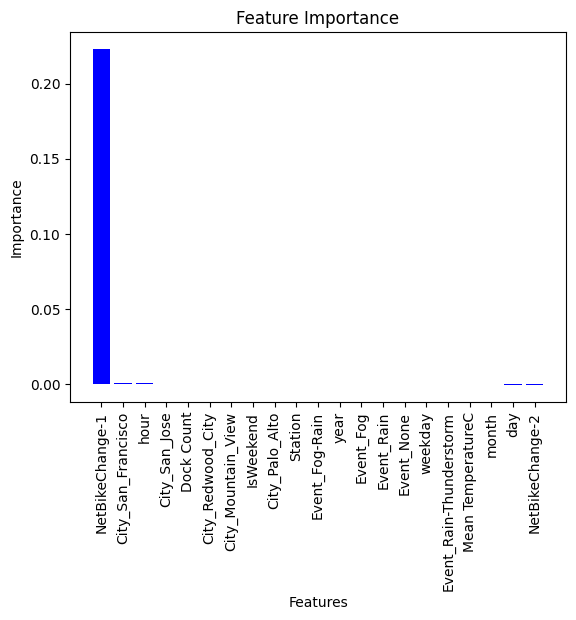

In [243]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(32, 16,8),random_state=1, max_iter=5)
mlp.fit(train_df_features, train_target)
predictions= mlp.predict(test_df_features)
mlp_test_MSE = mean_squared_error(test_target,predictions)
print(f"Multilayer perceptron: de MSE error op de test set is: {mlp_test_MSE}")

# Een alternatieve manier om het belang van de features te berekenen
result = permutation_importance(mlp, test_df_features, test_target, n_repeats=5, random_state=42)
feature_importances = result.importances_mean
MlpFeatures = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, coefficient in MlpFeatures:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(MlpFeatures)

Ondanks dat we een complexer, non-lineair model gebruiken zien we geen verbetering in performance, integendeel zelfs. Een zo complex mogelijk model op een probleem gooien is dus niet altijd de oplossing.<br>
De verandering van fietsen tijdens het vorige uur is hier veruit het belangrijkste feature.

# Visualiseer de resultaten

In [254]:
viz_data = test_df[(test_df['Station']==70)&(test_df['day']==11)&(test_df['month']==8)]
viz_data_target = viz_data['netBikeChange']
viz_data_features = viz_data.drop('netBikeChange',axis=1)

In [277]:
def plotPredictionVsReality(model,dailyFeature, dailyTarget):
    predictions = model.predict(dailyFeature)
    plt.figure(figsize=(8, 6))
    plt.plot(dailyFeature['hour'],predictions, label ='Predictions',color='r')
    plt.bar(dailyFeature['hour'], dailyTarget, label='Actual')
    plt.xlabel('Uur van de dag')
    plt.xticks(dailyFeature['hour'])
    plt.ylabel('Verandering van fietsen')
    plt.title(f'Voorspelling vs Realiteit')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adding origin lines (axes lines)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()


Lineaire regressie: lr
Ridge regression: ridgeCV
Decision tree:
Random forest: rf
Gradient Boosting: ensambleTree
multilayer perceptron: mlp

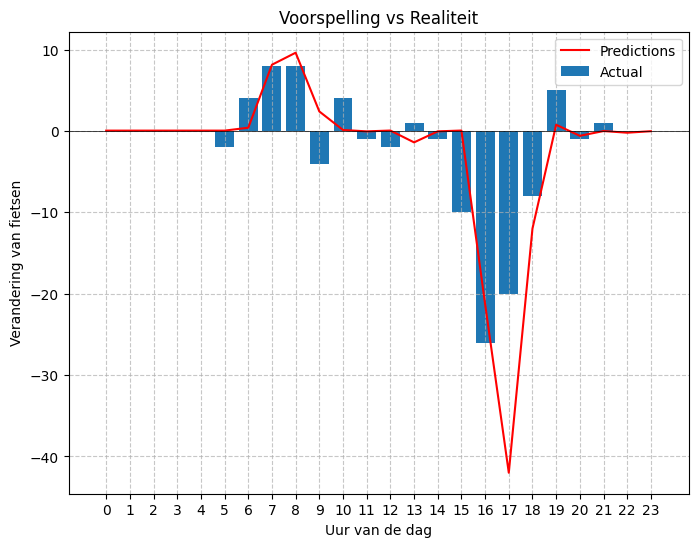

In [282]:
model = decTree
plotPredictionVsReality(model,viz_data_features,viz_data_target)